In [1]:
import sys
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sindy_utils import library_size, sindy_library
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, LassoCV


In [2]:
# Dynamical systems Functions

def lorenz(X, t, s=10, r=28, b=8/3):
    """Lorenz system."""
    x, y, z = X
    return [s*(y-x), x*(r-z)-y, x*y-b*z]

def rossler(X, t, a=0.2, b=0.2, c=5.7):
    """Rossler system."""
    x, y, z = X
    return -y-z, x+a*y, b+z*(x-c)

def lotka_volterra(X, t, a=1.5, b=1, c=3, d=1):
    """Lotka-Volterra system."""
    x, y = X
    return a*x - b*x*y, -c*y + d*x*y

##
def chua(X, a=15.6, b=28, m=0.2):
    """Chua system."""
    x, y, z = X
    return a*(y-x-m*x**3), x - y + z, -b*y


def chen(X, a=35, c=27, b=2.8):
    """Chua system."""
    x, y, z = X
    return a*(y-x), (c-a)*x - z*x + c*y, x*y - b*z

def henon(X, t, a=1.4, b=0.3):
    """Henon map."""
    x, y = X
    return 1 - a*x**2 + y, b*x

# Build hankel matrix from time series 1D 
def build_hankel_matrix(x, delay=30):
    """Build a Hankel matrix from a time series."""
    N = len(x)
    M = N - delay - 1
    hankel = np.zeros((delay, M))
    for i in range(delay):
        hankel[i, :] = x[i:i+M]
    return hankel

# Generate a time series for each of the dynamical systems above using scipy.integrate.odeint
from scipy.integrate import odeint

def generate_time_series(func, x0, t, args=()):
    """Generate a time series for a given dynamical system."""
    return odeint(func, x0, t).T


### Map dominant SVD modes from Hankel matrix to x

Let $\mathbf x(t)$ the solution of a dynamical system

$$ \frac{d\mathbf x}{dt} = \mathbf f_\mathbf{w}(x) $$

Let $H$ be the Hankel matrix with every column defined as 

$$\mathbf h(x_i; n, \tau) = [x_i(t), x_i(t + \tau), \ldots, x_i(t + (n-1)\tau)]$$

We find the dominant eigen-time modes of the time-delay embedding of $x$ using the SVD decomposition:

$$ H = U \Sigma V^T $$

We seek a polynomial map between $H$ and $\mathbf x$.

$$ \mathbf x = \boldsymbol \Phi_\mathbf{\bar w}(H) = \boldsymbol \Theta(H) \mathbf{\bar w}$$


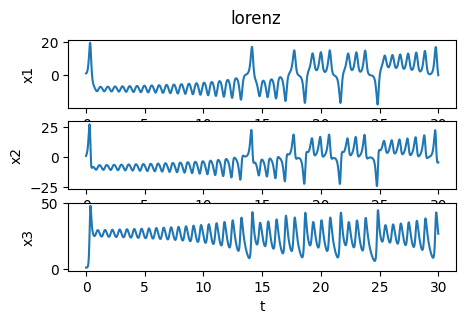

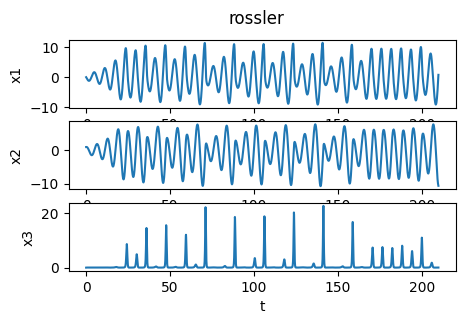

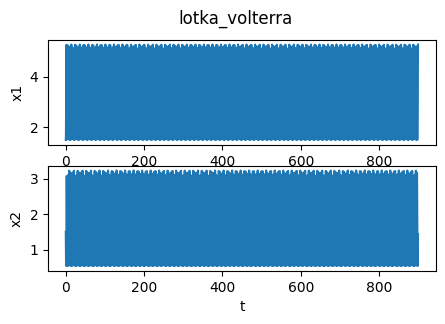

In [3]:
# %matplotlib widget

# Dynamical systems parameters
systems = [lorenz, rossler, lotka_volterra]#, chen]
x0s = [(1, 1.0, 1.0), (0, 1, 0), (1.5, 1.5)]#, (-0.1, 0.3, -0.6)] 
ndts = [0.1, .7, 3]#, .01] # n*dt is roughly the period of oscillation
num_step_per_period = 8 # number of time steps per period
periods = 300 # number of periods to simulate
ts = [np.linspace(0, int(periods*ndt), int(periods*num_step_per_period), endpoint=False) for i, ndt in enumerate(ndts)]
args = [() for i in range(len(systems))]

# SINDy parameters
plot_systems = True
poly_order = 3
nd = 3
delay = num_step_per_period
alpha = 0.4
project = False
usesine = False

# Training parameters
test_size = 0.2
random_state = 0

# Plot systems and their corresponding time series 
if plot_systems:
    for i, system in enumerate(systems):
        # generate time series
        X = generate_time_series(system, x0s[i], ts[i], args[i])
        # plot time series
        fig, ax = plt.subplots(len(x0s[i]), 1, figsize=(5, 3))
        for j in range(len(x0s[i])):
            ax[j].plot(ts[i], X[j, :])
            ax[j].set_xlabel('t')
            ax[j].set_ylabel('x{}'.format(j+1))
        plt.suptitle(system.__name__)
        plt.show()

In [4]:
# 1. Loop through dynamical systems models,
# 2. generate time series, and build hankel matrices
# 3. for each time series apply SVD to get the basis vectors (k rows of VT)
# 4. Then build a polynomial library in VT_k 
# 5. Train a linear model to fit the library to the original full-state time series


# Loop through dynamical systems
results = []
for system, x0, t, arg in zip(systems, x0s, ts, args):
    # Generate time series

    x = generate_time_series(system, x0, t, arg)

    # project on random vector
    if project:
        n = np.random.randn(x.shape[0])
        n = n/np.linalg.norm(n)
        xp = np.sum(x * n[:, None], axis=0)
    else:
        xp = x[0, :]
        n = None
    
    # Build hankel matrix
    H = build_hankel_matrix(xp, delay)
    Ht = H.T


    # # SVD
    # U, s, VT = np.linalg.svd(H, full_matrices=False)

    # v = np.matmul(VT[:nd, :].T, np.diag(s[:nd]))

    # Build polynomial library Assuming nd dominant modes
    
    X, names = sindy_library(Ht, poly_order, include_names=True, include_sine=False)


    # Split data into training and testing sets
    x_train, x_test, library_train, library_test = train_test_split(x[:, :X.shape[0]].T, X, 
                                                test_size=test_size, random_state=random_state,
                                                shuffle=False)
    
    
    # Train linear model
    model = Lasso(alpha=alpha, fit_intercept=False, max_iter=50000)
    model.fit(library_train, x_train)
    # print(model.coef_)

    # Evaluate model
    x_pred = model.predict(library_test)

    # Compute error
    error = np.linalg.norm(x_pred - x_test)/np.linalg.norm(x_test)
    score = model.score(library_test, x_test)
    num_zeros = np.sum(model.coef_ == 0.0)

    print('## ', system.__name__)
    print("Error: %f" % error)
    print("Score: %f" % score)

    print('sparsity : ', num_zeros/(np.prod(model.coef_.shape)))
    print('number of zeros : ', num_zeros, ' out of ', np.prod(model.coef_.shape))
    print('----')

    # Store results in list
    results.append((system.__name__, x_train, x_test, x_pred, 
        library_train, library_test, model, error, score, names, model.coef_, Ht, n))



c:\Users\USAID\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+02, tolerance: 1.545e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\USAID\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.804e+02, tolerance: 1.284e+02
  model = cd_fast.enet_coordinate_descent(


##  lorenz
Error: 0.154258
Score: 0.917938
sparsity :  0.8525252525252526
number of zeros :  422  out of  495
----


c:\Users\USAID\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e+02, tolerance: 4.186e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\USAID\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e+02, tolerance: 1.513e+00
  model = cd_fast.enet_coordinate_descent(


##  rossler
Error: 0.103205
Score: 0.959911
sparsity :  0.8949494949494949
number of zeros :  443  out of  495
----
##  lotka_volterra
Error: 0.007904
Score: 0.999622
sparsity :  0.9454545454545454
number of zeros :  312  out of  330
----


[[-0.00000000e+00  9.26183541e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.52609430e-05 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -1.56612832e-04 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -1.95472067e-05  1.46692338e-03  0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.92487092e-04 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000

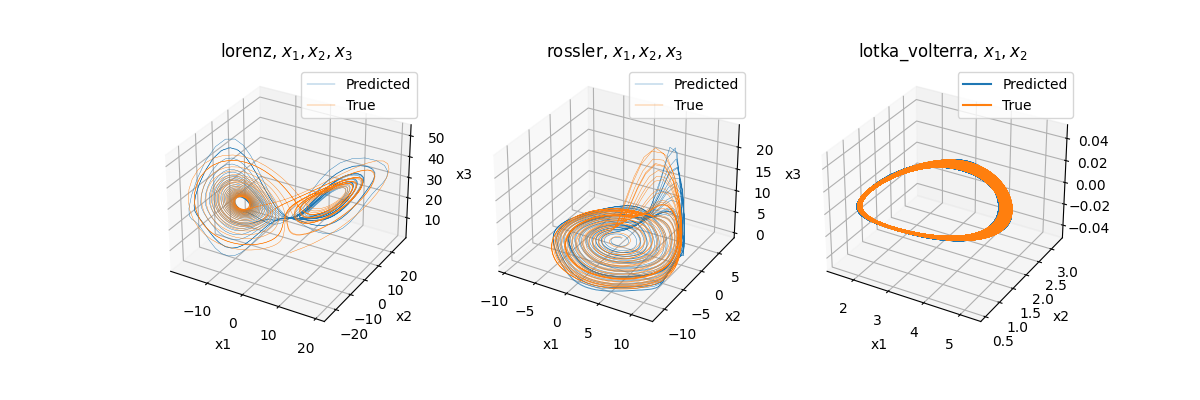

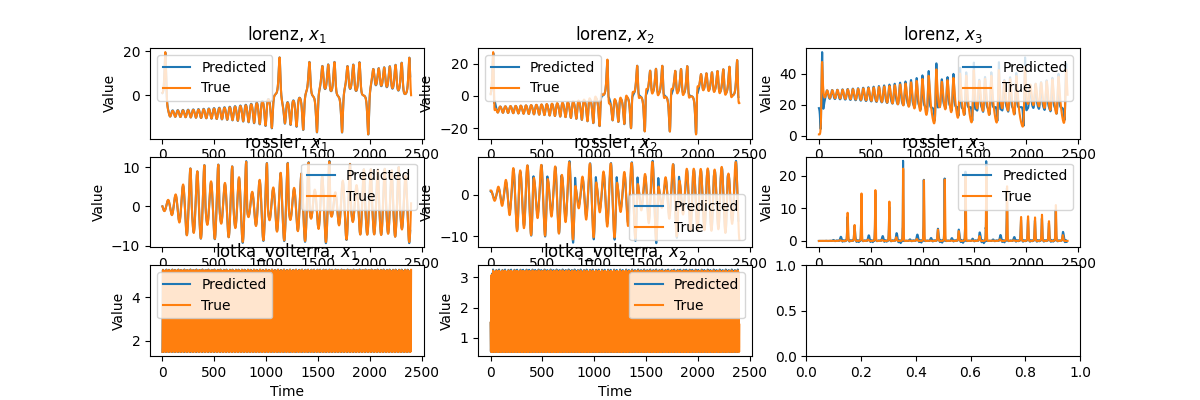

In [5]:
%matplotlib widget
# import numpy as np
# Plot results till time 10
iend = 50000 
# Plot results
fig1, axes = plt.subplots(len(systems), 3, figsize=(12, 4))
fig2 = plt.figure(figsize=(12, 4))

for i, (name, x_train, x_test, x_pred, library_train, library_test, model, error, score, names, coef, Ht, n) in enumerate(results):
    if i >3:
        continue
    ax3d = fig2.add_subplot(1, 3, i+1, projection='3d')

    nper = 1.0
    t = np.linspace(0, int(nper*periods*ndts[i]), int(nper*periods*num_step_per_period), endpoint=False)
    x = generate_time_series(systems[i], x0s[i], t, args[i])

    if project:
        xp = np.sum(x * n[:, None], axis=0)
    else:
        xp = x[0, :]

    H = build_hankel_matrix(xp, delay)
    Ht = H.T
    # U, s, VT = np.linalg.svd(H, full_matrices=False)
    # v = np.matmul(VT[:nd, :].T, np.diag(s[:nd]))
    X, names = sindy_library(Ht, poly_order, include_names=True, include_sine=False)
    x_pred = model.predict(X).T

    print(model.coef_)

    for j in range(x_test.shape[1]):

        axes[i, j].plot(x_pred[j, :iend], label='Predicted')
        axes[i, j].plot(x[j, :iend], label='True')
        axes[i, j].set_title("%s, $x_%d$" % (name, j+1))
        axes[i, j].set_xlabel("Time")
        axes[i, j].set_ylabel("Value")
        axes[i, j].legend()
            
    if x_test.shape[1] == 3:
        ax3d.plot(x_pred[0, :iend], x_pred[1, :iend], x_pred[2, :iend], lw=.3,label='Predicted')
        ax3d.plot(x[0, :iend], x[1, :iend], x[2, :iend], lw=.3,label='True')
        ax3d.set_title("%s, $x_1, x_2, x_3$" % (name))
        ax3d.set_xlabel("x1")
        ax3d.set_ylabel("x2")
        ax3d.set_zlabel("x3")
        ax3d.legend()

    elif x_test.shape[1] == 2:
        ax3d.plot(x_pred[0, :], x_pred[1, :], label='Predicted')
        ax3d.plot(x[0, :x_pred.shape[1]], x[1, :x_pred.shape[1]], label='True')
        ax3d.set_title("%s, $x_1, x_2$" % (name))
        ax3d.set_xlabel("x1")
        ax3d.set_ylabel("x2")
        ax3d.legend()


# plt.tight_layout()
plt.show()

